In [1]:
#!pip install optuna

In [ ]:
## data wrangling
import pandas as pd
import numpy as np


## sklearn
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, plot_roc_curve

## balancing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

## optuna
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

## visualization
import matplotlib.pyplot as plt
import seaborn as sns

## joblib
import joblib

SEED = 42
np.random.seed(SEED)

## The Dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/LEON240196/PF_ML/main/heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [ ]:
df.dtypes

HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

## Data Types

In [ ]:
cat_cols = df.drop('HeartDisease', axis=1).select_dtypes(include="object").columns.to_list()
num_cols = df.select_dtypes(include="float").columns.to_list()

In [ ]:
scale_numeric = Pipeline(steps=[('scaling', StandardScaler())])
onehot_categories = Pipeline(steps=[ ('one_hot', OneHotEncoder(drop='if_binary'))])

In [ ]:
preprocess_columns = ColumnTransformer(transformers=[('number', scale_numeric, num_cols),
                                                     ('one_hot', onehot_categories, cat_cols)
                                                    ])

In [ ]:
pipeline = Pipeline(steps=[('preprocess', preprocess_columns)])

## Features and Target

In [ ]:
X = df.drop(columns=['HeartDisease'], axis=1)
y = df['HeartDisease']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=44, stratify=y)

## Over and Under sampling

In [ ]:
over_sampler = RandomOverSampler(sampling_strategy=0.43)

In [ ]:
X_train_res, y_train_res = over_sampler.fit_resample(X_train, y_train)

y_train_res.value_counts()

No     175453
Yes     75444
Name: HeartDisease, dtype: int64

In [ ]:
under_sampler = RandomUnderSampler()

In [ ]:
X_train_res, y_train_res = under_sampler.fit_resample(X_train_res, y_train_res)


In [ ]:
y_train_res.value_counts()

No     75444
Yes    75444
Name: HeartDisease, dtype: int64

In [ ]:
label_encoder = LabelEncoder()

y_train_res = label_encoder.fit_transform(y_train_res)
y_test = label_encoder.transform(y_test)

In [ ]:
y_train_res

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
X_train_processed = pipeline.fit_transform(X_train_res)

In [ ]:
X_test = pipeline.fit_transform(X_test)

In [ ]:
def objective(trial):
    x, y = X_train_processed, y_train_res
    
    classifier_name = trial.suggest_categorical('classifier', ['SGDClassifier', 'LogisticRegression', 'RandomForest'])
    if classifier_name == 'SGDClassifier':
        SGDC_alpha = trial.suggest_float('SGDC_alpha', 1e-10, 1e10, log=True)
        SGDC_penalty = trial.suggest_categorical('SGDCC_penalty', ['l1', 'l2', 'elasticnet'])
        SGDC_loss = trial.suggest_categorical('SGDCC_loss', ['hinge', 'log_loss', 'squared_error', 'log'])
        SGDC_max_iter = trial.suggest_float('SGDC_max_iter', 1, 10000, log=True)
        classifier_obj = sklearn.linear_model.SGDClassifier(penalty=SGDC_penalty, alpha=SGDC_alpha, max_iter=SGDC_max_iter)
            
    elif classifier_name == 'LogisticRegression':
      LogisticRegression_penalty = trial.suggest_categorical('LogisticRegression_penalty', ['l2', 'l1',])
      LogisticRegression_c = trial.suggest_float('LogisticRegression_c', 1e-4, 1e2, log=False)
      LogisticRegression_solver = trial.suggest_categorical('LogisticRegression_solver', [ 'liblinear','saga'])
      LogisticRegression_fit_intercept = trial.suggest_categorical('LogisticRegression_fit_intercept', [False, True])
      classifier_obj = sklearn.linear_model.LogisticRegression(
          penalty=LogisticRegression_penalty, C=LogisticRegression_c, solver=LogisticRegression_solver, fit_intercept = LogisticRegression_fit_intercept)
      
    else :
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 200, log=True)
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 100, 500, log=True)
        rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
        rf_max_features = trial.suggest_categorical('rf_max_features', ['auto', 'sqrt', 'log2'])
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators, criterion=rf_criterion,
        max_features=rf_max_features)
        
        
    score = sklearn.model_selection.cross_val_score(classifier_obj, x, 
                                  y, n_jobs=-1, cv=3
                                                )
    accuracy = score.mean()
    print(accuracy)
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2022-06-11 05:17:22,375] A new study created in memory with name: no-name-d9a9c3b4-f6b2-405b-8f76-26a7c5ee9bfd
[I 2022-06-11 05:17:25,509] Trial 0 finished with value: 0.7638115688457664 and parameters: {'classifier': 'LogisticRegression', 'LogisticRegression_penalty': 'l1', 'LogisticRegression_c': 59.249290658224915, 'LogisticRegression_solver': 'liblinear', 'LogisticRegression_fit_intercept': True}. Best is trial 0 with value: 0.7638115688457664.


0.7638115688457664


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-06-11 05:25:20,475] Trial 1 finished with value: 0.9167859604474842 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 101, 'rf_n_estimators': 103, 'rf_criterion': 'gini', 'rf_max_features': 'auto'}. Best is trial 1 with value: 0.9167859604474842.


0.9167859604474842


[I 2022-06-11 05:25:22,291] Trial 2 finished with value: 0.7637983139812311 and parameters: {'classifier': 'LogisticRegression', 'LogisticRegression_penalty': 'l2', 'LogisticRegression_c': 45.51925942618942, 'LogisticRegression_solver': 'liblinear', 'LogisticRegression_fit_intercept': True}. Best is trial 1 with value: 0.9167859604474842.


0.7637983139812311


[I 2022-06-11 05:25:24,397] Trial 3 finished with value: 0.7637983139812311 and parameters: {'classifier': 'LogisticRegression', 'LogisticRegression_penalty': 'l2', 'LogisticRegression_c': 49.89500017256037, 'LogisticRegression_solver': 'saga', 'LogisticRegression_fit_intercept': False}. Best is trial 1 with value: 0.9167859604474842.


0.7637983139812311


[I 2022-06-11 05:25:25,732] Trial 4 finished with value: 0.7638049414134988 and parameters: {'classifier': 'LogisticRegression', 'LogisticRegression_penalty': 'l2', 'LogisticRegression_c': 11.561886658766458, 'LogisticRegression_solver': 'liblinear', 'LogisticRegression_fit_intercept': True}. Best is trial 1 with value: 0.9167859604474842.


0.7638049414134988


[I 2022-06-11 05:25:26,905] Trial 5 finished with value: 0.7101890143682731 and parameters: {'classifier': 'SGDClassifier', 'SGDC_alpha': 1.4983495281817994e-07, 'SGDCC_penalty': 'l2', 'SGDCC_loss': 'log', 'SGDC_max_iter': 23.68685275873723}. Best is trial 1 with value: 0.9167859604474842.


0.7101890143682731


[I 2022-06-11 05:25:28,796] Trial 6 finished with value: 0.7584367212767086 and parameters: {'classifier': 'SGDClassifier', 'SGDC_alpha': 3.818120741996294e-05, 'SGDCC_penalty': 'elasticnet', 'SGDCC_loss': 'log_loss', 'SGDC_max_iter': 59.85103065881754}. Best is trial 1 with value: 0.9167859604474842.


0.7584367212767086


[I 2022-06-11 05:25:29,758] Trial 7 finished with value: 0.7638115688457664 and parameters: {'classifier': 'LogisticRegression', 'LogisticRegression_penalty': 'l1', 'LogisticRegression_c': 80.61707795477147, 'LogisticRegression_solver': 'liblinear', 'LogisticRegression_fit_intercept': True}. Best is trial 1 with value: 0.9167859604474842.


0.7638115688457664


[I 2022-06-11 05:25:43,385] Trial 8 finished with value: 0.727533004612693 and parameters: {'classifier': 'SGDClassifier', 'SGDC_alpha': 1.409259390331585e-07, 'SGDCC_penalty': 'l2', 'SGDCC_loss': 'hinge', 'SGDC_max_iter': 1199.280147082313}. Best is trial 1 with value: 0.9167859604474842.


0.727533004612693


[I 2022-06-11 05:26:07,240] Trial 9 finished with value: 0.6894650336673559 and parameters: {'classifier': 'SGDClassifier', 'SGDC_alpha': 2.949636220204411e-10, 'SGDCC_penalty': 'l1', 'SGDCC_loss': 'log_loss', 'SGDC_max_iter': 841.0410667661704}. Best is trial 1 with value: 0.9167859604474842.


0.6894650336673559
FrozenTrial(number=1, values=[0.9167859604474842], datetime_start=datetime.datetime(2022, 6, 11, 5, 17, 25, 517959), datetime_complete=datetime.datetime(2022, 6, 11, 5, 25, 20, 474665), params={'classifier': 'RandomForest', 'rf_max_depth': 101, 'rf_n_estimators': 103, 'rf_criterion': 'gini', 'rf_max_features': 'auto'}, distributions={'classifier': CategoricalDistribution(choices=('SGDClassifier', 'LogisticRegression', 'RandomForest')), 'rf_max_depth': IntLogUniformDistribution(high=200, low=2, step=1), 'rf_n_estimators': IntLogUniformDistribution(high=500, low=100, step=1), 'rf_criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'rf_max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)


In [ ]:
plot_optimization_history(study)


In [ ]:
plot_parallel_coordinate(study)


In [ ]:
plot_parallel_coordinate(study, params=['rf_n_estimators', 'rf_max_depth', 'rf_max_features', 'rf_criterion'])


In [ ]:
plot_contour(study, params=['rf_n_estimators', 'rf_max_depth', 'rf_max_features', 'rf_criterion'])


[W 2022-06-11 05:26:07,955] Param rf_criterion unique value length is less than 2.
[W 2022-06-11 05:26:07,971] Param rf_criterion unique value length is less than 2.
[W 2022-06-11 05:26:07,987] Param rf_criterion unique value length is less than 2.
[W 2022-06-11 05:26:08,002] Param rf_max_depth unique value length is less than 2.
[W 2022-06-11 05:26:08,016] Param rf_max_depth unique value length is less than 2.
[W 2022-06-11 05:26:08,028] Param rf_max_depth unique value length is less than 2.
[W 2022-06-11 05:26:08,038] Param rf_max_features unique value length is less than 2.
[W 2022-06-11 05:26:08,050] Param rf_max_features unique value length is less than 2.
[W 2022-06-11 05:26:08,069] Param rf_max_features unique value length is less than 2.
[W 2022-06-11 05:26:08,080] Param rf_n_estimators unique value length is less than 2.
[W 2022-06-11 05:26:08,092] Param rf_n_estimators unique value length is less than 2.
[W 2022-06-11 05:26:08,101] Param rf_n_estimators unique value length is

In [ ]:
plot_slice(study)


In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [ ]:
plot_edf(study)


In [ ]:
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.9165009808599756
  Params: 
    classifier: RandomForest
    rf_max_depth: 106
    rf_n_estimators: 146
    rf_criterion: entropy
    rf_max_features: auto


In [ ]:
model = RandomForestClassifier(max_depth = 38, n_estimators=299,criterion='gini',max_features = 'sqrt')

In [ ]:
model.fit(X_train_processed,y_train_res)

RandomForestClassifier(max_depth=38, max_features='sqrt', n_estimators=299)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92    116969
           1       0.28      0.46      0.35     10949

    accuracy                           0.85    127918
   macro avg       0.61      0.67      0.63    127918
weighted avg       0.89      0.85      0.87    127918



In [ ]:
def plot_feature_importance(importance,names,model_type, top=100):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:top], y=fi_df['feature_names'][:top])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
## get features
one_hot = OneHotEncoder(drop="if_binary")

features_list = one_hot.fit_transform(X_train.select_dtypes(include="object"))

one_hot.get_feature_names_out()

array(['Smoking_Yes', 'AlcoholDrinking_Yes', 'Stroke_Yes',
       'DiffWalking_Yes', 'Sex_Male', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79',
       'AgeCategory_80 or older', 'Race_American Indian/Alaskan Native',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other',
       'Race_White', 'Diabetic_No', 'Diabetic_No, borderline diabetes',
       'Diabetic_Yes', 'Diabetic_Yes (during pregnancy)',
       'PhysicalActivity_Yes', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good',
       'Asthma_Yes', 'KidneyDisease_Yes', 'SkinCancer_Yes'], dtype=object)

In [ ]:
len(model.feature_importances_)

41

In [ ]:
len(one_hot.get_feature_names_out())

37

In [ ]:
len(X_train.select_dtypes(include="number").columns) + len(one_hot.get_feature_names_out())

41

In [ ]:
features = np.concatenate((X_train.select_dtypes(include="number").columns, one_hot.get_feature_names_out()))
features

array(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime',
       'Smoking_Yes', 'AlcoholDrinking_Yes', 'Stroke_Yes',
       'DiffWalking_Yes', 'Sex_Male', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79',
       'AgeCategory_80 or older', 'Race_American Indian/Alaskan Native',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other',
       'Race_White', 'Diabetic_No', 'Diabetic_No, borderline diabetes',
       'Diabetic_Yes', 'Diabetic_Yes (during pregnancy)',
       'PhysicalActivity_Yes', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good',
       'Asthma_Yes', 'KidneyDisease_Yes', 'SkinCancer_Yes'], dtype=object)

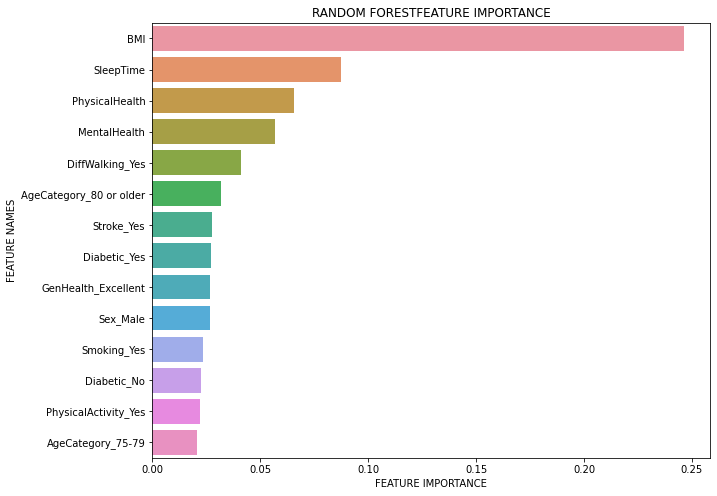

In [ ]:
plot_feature_importance(model.feature_importances_,features,'RANDOM FOREST', top=14)

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

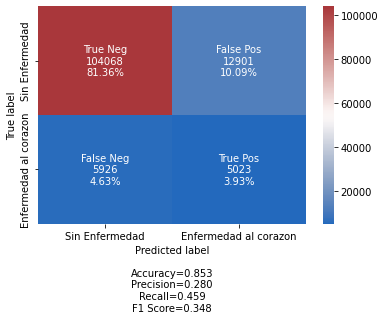

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Sin Enfermedad', 'Enfermedad al corazon']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='vlag')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



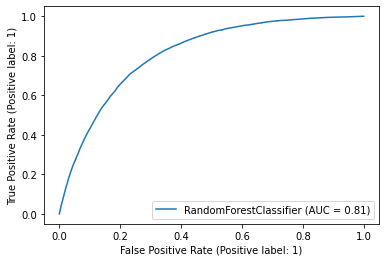

In [ ]:
plot_roc_curve(model, X_test, y_test)

In [ ]:
production_pipeline = Pipeline(steps=[('preprocess', preprocess_columns),
                                      ('model', RandomForestClassifier(max_depth = 38, n_estimators=299,criterion='gini',max_features = 'sqrt'))])

In [ ]:
production_pipeline.fit(X_train_res, y_train_res)

KeyboardInterrupt: ignored

In [ ]:
joblib.dump(production_pipeline, 'Hiramonos.joblib')

FIN